In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from statsmodels.stats.multitest import multipletests
from scipy.cluster.hierarchy import linkage, leaves_list

In [2]:
# PARAMETERS
run_id="group_loops.09.19.ldcts"

In [3]:
# Parameters
run_id = "hypo_DMRs.09.19.ldcts"


In [4]:
selected_traits = {
    "Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia_" : "Alzheimers Disease and Dementia", 
    "Nalls.LancetNeurol.2019.Parkinsons_disease_" : "Parkinson's Disease", 
    "PGC.Nature.2014.Schizophrenia_" : "Schizophrenia", 
    "Wray.biorxiv.2018.Major_Depressive_Disorder_" : "Major Depressive Disorder", 
    "Demontis.NatGenet.2019.Attention_Deficit_Hyperactivity_Disorder_" : "ADHD", 
    "Mullins.NatGenet.2021.Bipolar_Disorder_" : "Bipolar Disorder", 
    "Grove.NatGenet.2019.Autism_Spectrum_Disorder_" : "Autism Spectrum Disorder", 
    "Jansen.2019.NatGenet.Insomnia_" : "Insomnia", 
    "PGC.MolPsychiatry.2017.Obsessive_Compulsive_Disorder_" : "Obsessive Compulsive Disorder", 
    "Deary.MolPsychiatry.2017.Tiredness_" : "Tiredness", 
    "IMSGC.Science.2019.Multiple_sclerosis_" : "Multiple Sclerosis", 
    "Luciano.NatGenet.2017.Neuroticism_" : "Neuroticism", 
    "Okbay.Nature.2016.Educational_Attainment_" : "Educational Attainment", 
    "Palmer.MolPsych.2021.problematic_opioid_use_" : "Problematic Opioid Use", 
    "Savage.NatGenet.2018.Intelligence_" : "Intelligence", 
    "vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_" : "Amyotrophic Lateral Sclerosis", 
    "Barban.NatGenet.2016.Age_First_Birth_" : "Age at First Birth", 
    "Chiou.Nature.2021.Type_1_diabetes_" : "Type 1 Diabetes", 
    "Watson.2018.NatGenet.Anorexia_Nervosa_" : "Anorexia Nervosa"
}

In [5]:
ldsc_results=f'/anvil/projects/x-mcb130189/rwang22/bican/ldsc/output/{run_id}'
directory = Path(ldsc_results)
dfs = {}

for file in directory.glob(f'*.cell_type_results.txt'):
    cur = pd.read_csv(file, sep = "\t")
    stripped = file.stem.replace(f'_.cell_type_results', "")
    cur["Trait"] = stripped
    dfs[stripped] = cur

In [6]:
combined_df = pd.concat(dfs.values(), ignore_index=True)
combined_df["-log10(pval)"] = -np.log10(combined_df["Coefficient_P_value"])
combined_df["Trait"] = combined_df["Trait"].str.replace(f'{run_id}.cell_type_results', "")
combined_df = combined_df[combined_df["Trait"].isin(selected_traits.keys())] # only predetermined selected traits
combined_df.head()

/tmp/ipykernel_1910065/638502812.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  combined_df["Trait"] = combined_df["Trait"].str.replace(f'{run_id}.cell_type_results', "")


,Name,Coefficient,Coefficient_std_error,Coefficient_P_value,Trait,-log10(pval)
0,SN_PAX7_GABA,4.058533e-08,1.593970e-08,0.005445,Wray.biorxiv.2018.Major_Depressive_Disorder_,2.263966
1,F_Glut,3.151255e-08,1.316288e-08,0.008332,Wray.biorxiv.2018.Major_Depressive_Disorder_,2.079260
2,CN_ST18_GABA,1.646352e-08,9.851759e-09,0.047348,Wray.biorxiv.2018.Major_Depressive_Disorder_,1.324694
3,STR_SST-CHODL_GABA,2.417333e-08,1.517775e-08,0.055616,Wray.biorxiv.2018.Major_Depressive_Disorder_,1.254802
4,OPC,1.898285e-08,1.287086e-08,0.070124,Wray.biorxiv.2018.Major_Depressive_Disorder_,1.154136


In [7]:
# Perform FDR correction using Benjamini-Hochberg procedure
rejected, q_values, _, _ = multipletests(combined_df["Coefficient_P_value"], alpha=0.05, method='fdr_bh')
combined_df["FDR_BH_corrected"] = q_values

In [8]:
# calculate the FDR p value threshold 
# https://www.r-bloggers.com/2023/07/the-benjamini-hochberg-procedure-fdr-and-p-value-adjusted-explained/

def fdr_bh_adj(df):
    tmp = combined_df.copy()
    tmp["rank"] =  combined_df['Coefficient_P_value'].rank()
    num_tests = len(tmp)
    tmp["adj_pval"] = (num_tests * tmp["Coefficient_P_value"]) / tmp["rank"]

    return tmp


In [9]:
tmp = fdr_bh_adj(combined_df)
# Align indices before comparison
fdr_bh_corrected = combined_df["FDR_BH_corrected"]
adj_pval = tmp["adj_pval"]

print(fdr_bh_corrected.sort_values())

1922    0.048736
1024    0.048736
1023    0.048736
1178    0.048736
1179    0.048736
          ...   
3068    0.992147
1640    0.992147
1641    0.994233
1642    0.996443
2293    0.996879
Name: FDR_BH_corrected, Length: 589, dtype: float64


In [10]:
print(adj_pval.sort_values())

1922    0.048736
1179    0.048965
3007    0.054423
217     0.055892
1178    0.060944
          ...   
680     0.996963
1053    0.997705
1115    0.998839
2912    1.000252
3068    1.000270
Name: adj_pval, Length: 589, dtype: float64


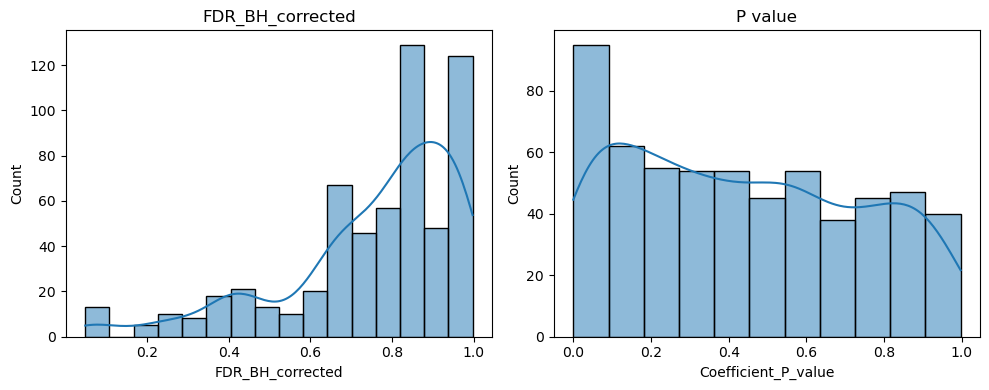

In [11]:
# plot the distribution of p values 
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# First plot
sns.histplot(combined_df["FDR_BH_corrected"], kde=True, ax=axes[0])
axes[0].set_title("FDR_BH_corrected")

# Second plot
sns.histplot(combined_df["Coefficient_P_value"], kde=True, ax=axes[1])
axes[1].set_title("P value")

plt.tight_layout()
plt.show()

In [12]:
modified_df = combined_df.drop(['Coefficient', 'Coefficient_std_error', 'Coefficient_P_value', 'FDR_BH_corrected'], axis=1)
modified_df = modified_df.pivot(index="Name", columns="Trait", values="-log10(pval)").reset_index()
modified_df = modified_df.set_index("Name")
modified_df.head()

Trait,Barban.NatGenet.2016.Age_First_Birth_,Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia_,Chiou.Nature.2021.Type_1_diabetes_,Deary.MolPsychiatry.2017.Tiredness_,Demontis.NatGenet.2019.Attention_Deficit_Hyperactivity_Disorder_,Grove.NatGenet.2019.Autism_Spectrum_Disorder_,IMSGC.Science.2019.Multiple_sclerosis_,Jansen.2019.NatGenet.Insomnia_,Luciano.NatGenet.2017.Neuroticism_,Mullins.NatGenet.2021.Bipolar_Disorder_,Nalls.LancetNeurol.2019.Parkinsons_disease_,Okbay.Nature.2016.Educational_Attainment_,PGC.MolPsychiatry.2017.Obsessive_Compulsive_Disorder_,PGC.Nature.2014.Schizophrenia_,Palmer.MolPsych.2021.problematic_opioid_use_,Savage.NatGenet.2018.Intelligence_,Watson.2018.NatGenet.Anorexia_Nervosa_,Wray.biorxiv.2018.Major_Depressive_Disorder_,vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_
Name,,,,,,,,,,,,,,,,,,,
ACx_MEIS2_GABA,0.232824,0.316907,0.203286,1.323304,0.042577,0.119183,0.103054,0.271378,0.384184,0.298642,1.003581,0.321696,0.089697,0.297414,0.287929,0.440014,0.447823,0.535012,0.037805
Astrocyte,0.494050,0.005714,0.210853,0.100209,1.480866,0.772125,0.183480,0.056726,0.648819,1.233191,0.563579,0.007163,0.252838,0.451405,0.149792,1.053778,1.504761,1.100992,0.195966
CN_Cholinergic_GABA,0.414498,0.061066,0.785965,1.192334,0.580942,0.146945,0.016710,0.366278,0.347772,0.730986,0.468165,0.394674,0.494027,0.519940,0.117898,0.634069,0.107686,0.534741,0.086498
CN_GABA-Glut,0.872583,0.461656,0.080748,0.294772,0.054236,0.867460,0.040647,0.047554,0.586119,0.513920,1.575365,0.118019,0.435717,0.161828,0.177869,1.873776,0.281748,0.233068,0.110119
CN_LAMP5-CXCL14_GABA,0.212705,0.307820,0.033256,0.028300,0.021856,0.068688,0.047382,0.367142,0.121638,1.596549,0.060043,0.278544,0.434688,0.337101,0.265160,0.452462,0.560015,1.042921,0.096777


In [13]:
fdr_modified_df = combined_df.drop(['Coefficient', 'Coefficient_std_error', 'Coefficient_P_value', '-log10(pval)'], axis=1)
fdr_modified_df = fdr_modified_df.pivot(index="Name", columns="Trait", values="FDR_BH_corrected").reset_index()
fdr_modified_df = fdr_modified_df.set_index("Name")
fdr_modified_df.head()

Trait,Barban.NatGenet.2016.Age_First_Birth_,Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia_,Chiou.Nature.2021.Type_1_diabetes_,Deary.MolPsychiatry.2017.Tiredness_,Demontis.NatGenet.2019.Attention_Deficit_Hyperactivity_Disorder_,Grove.NatGenet.2019.Autism_Spectrum_Disorder_,IMSGC.Science.2019.Multiple_sclerosis_,Jansen.2019.NatGenet.Insomnia_,Luciano.NatGenet.2017.Neuroticism_,Mullins.NatGenet.2021.Bipolar_Disorder_,Nalls.LancetNeurol.2019.Parkinsons_disease_,Okbay.Nature.2016.Educational_Attainment_,PGC.MolPsychiatry.2017.Obsessive_Compulsive_Disorder_,PGC.Nature.2014.Schizophrenia_,Palmer.MolPsych.2021.problematic_opioid_use_,Savage.NatGenet.2018.Intelligence_,Watson.2018.NatGenet.Anorexia_Nervosa_,Wray.biorxiv.2018.Major_Depressive_Disorder_,vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_
Name,,,,,,,,,,,,,,,,,,,
ACx_MEIS2_GABA,0.866012,0.855204,0.880269,0.419188,0.969141,0.947905,0.950063,0.866012,0.825519,0.862691,0.584163,0.850952,0.955076,0.862691,0.862691,0.793434,0.792587,0.754118,0.970784
Astrocyte,0.765429,0.992147,0.873022,0.950450,0.402332,0.658718,0.909523,0.969141,0.707300,0.460775,0.754118,0.992147,0.866012,0.789053,0.929131,0.553617,0.400946,0.524485,0.893099
CN_Cholinergic_GABA,0.801664,0.969141,0.658718,0.470205,0.736130,0.929157,0.985683,0.828164,0.829458,0.678544,0.781553,0.819544,0.765429,0.761109,0.947905,0.707300,0.950063,0.754118,0.959509
CN_GABA-Glut,0.643481,0.788569,0.962801,0.862691,0.969141,0.643481,0.970784,0.969141,0.730887,0.761109,0.381914,0.947905,0.793434,0.913913,0.910577,0.281307,0.866012,0.866012,0.950063
CN_LAMP5-CXCL14_GABA,0.873022,0.862691,0.970784,0.973962,0.980382,0.969141,0.969141,0.828164,0.947905,0.372826,0.969141,0.866012,0.793434,0.829458,0.866012,0.789053,0.754118,0.561656,0.950450


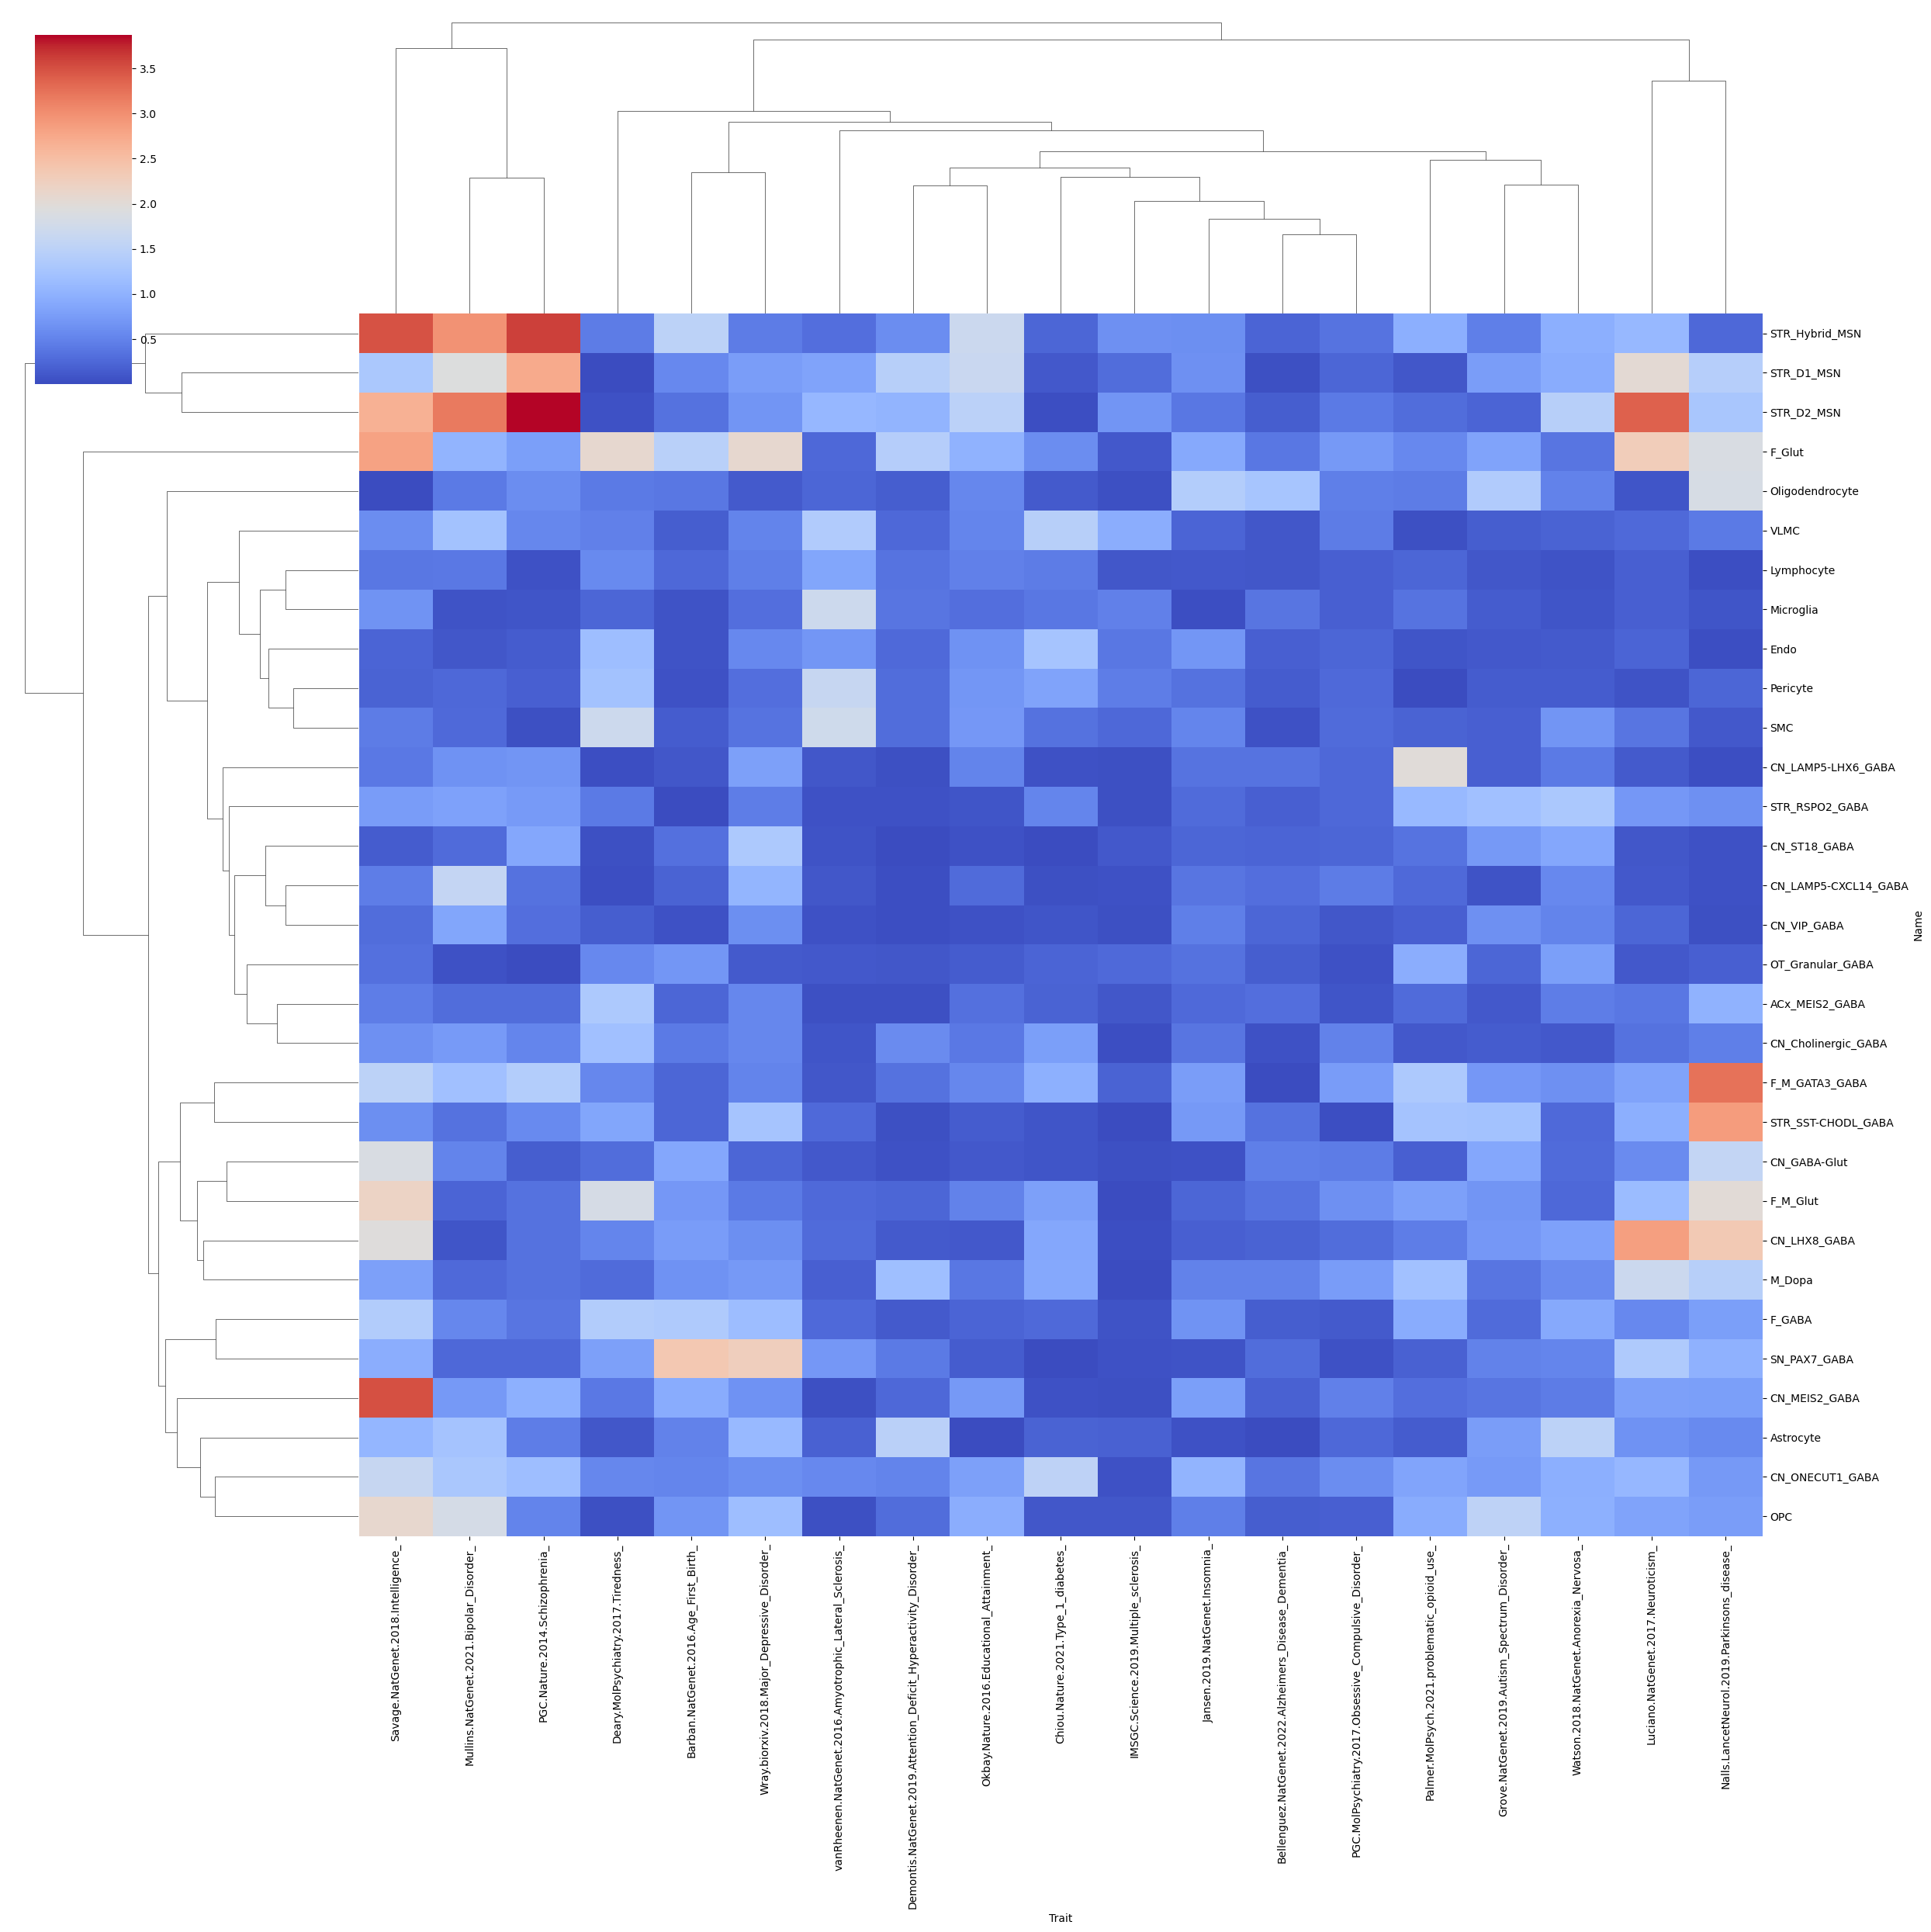

In [14]:
g = sns.clustermap(modified_df, cmap='coolwarm', figsize=(25, 25))

plt.show()
g.savefig(f'output/{run_id}_filtered.pdf')

In [15]:
def pval_to_star(p):
    if p < 1e-7:
        return '***'
    elif p < 1e-5:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

In [16]:
# Cluster rows
linkage_rows = linkage(modified_df.values, method="average", metric="euclidean")
row_order = leaves_list(linkage_rows)

# Cluster columns
linkage_cols = linkage(modified_df.values.T, method="average", metric="euclidean")
col_order = leaves_list(linkage_cols)

modified_df = modified_df.iloc[row_order, col_order].rename(columns = selected_traits)
fdr_modified_df = fdr_modified_df.iloc[row_order, col_order].rename(columns = selected_traits)

In [17]:
fdr_modified_df = fdr_modified_df.reindex(
    index=modified_df.index,    # same row order as df
    columns=modified_df.columns # same column order as df
)

In [18]:
cols_to_keep = fdr_modified_df.loc[:, (fdr_modified_df < 0.05).any()].columns
cols_to_keep

Index(['Intelligence', 'Schizophrenia', 'Neuroticism'], dtype='object', name='Trait')

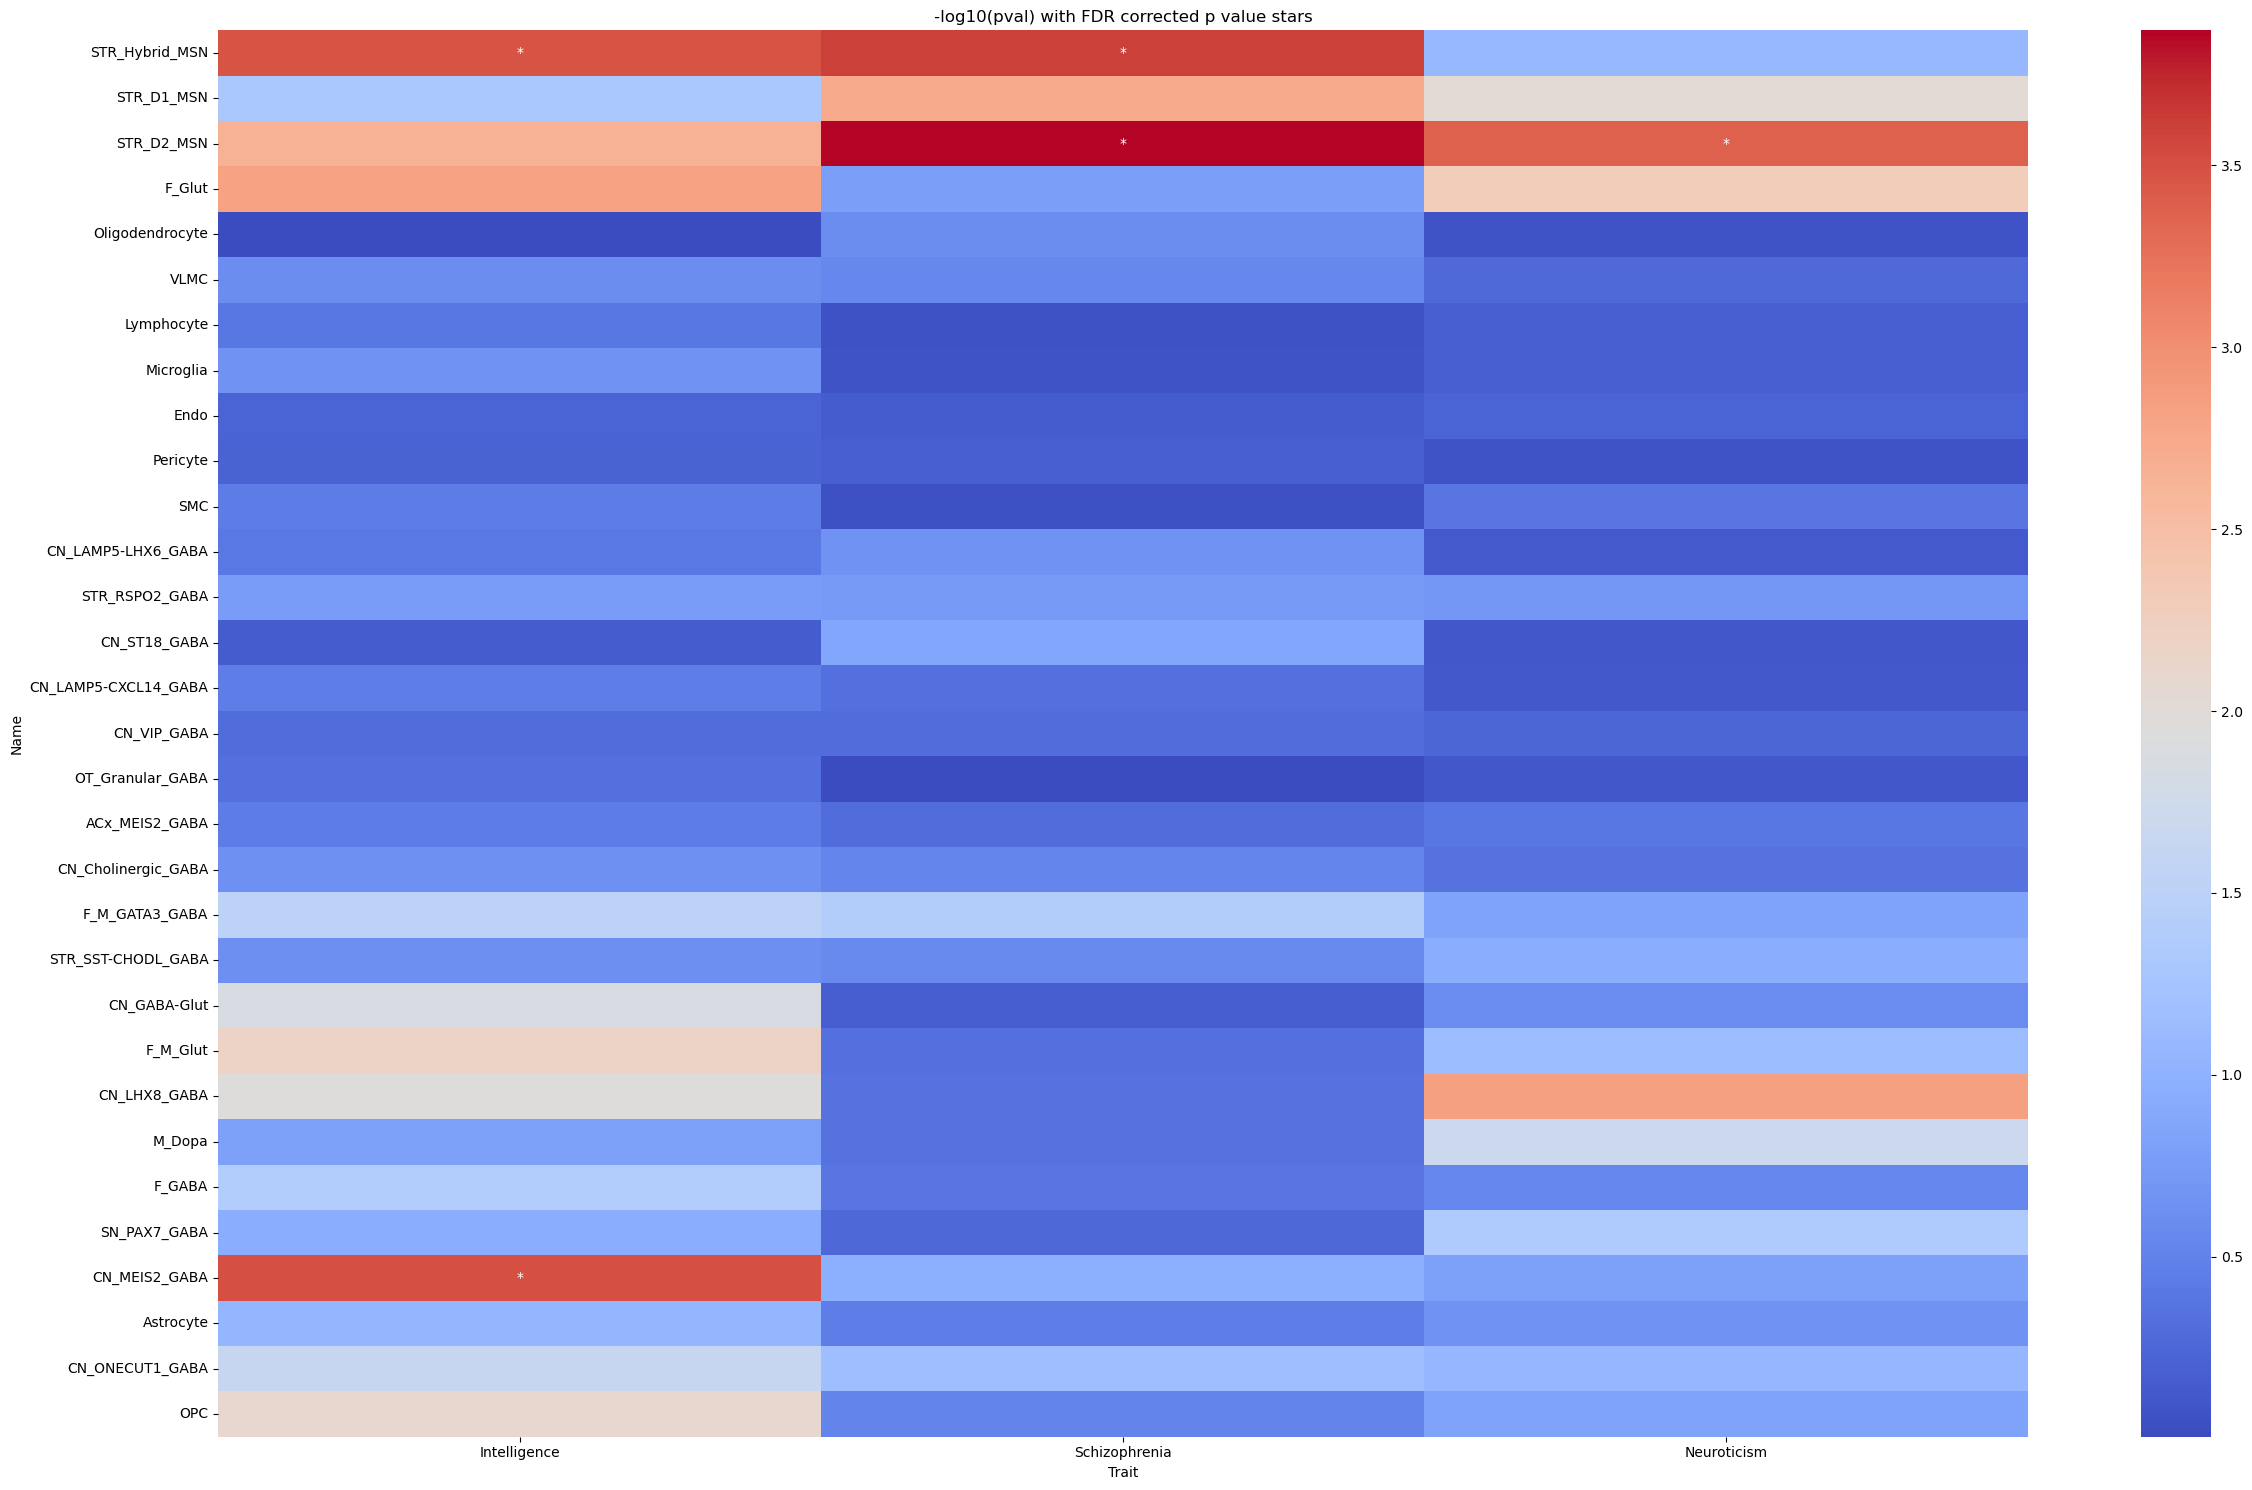

In [19]:
stars = fdr_modified_df[cols_to_keep].applymap(pval_to_star)

# Plot heatmap with annotations
plt.figure(figsize=(25, 15))
sns.heatmap(modified_df[cols_to_keep], annot=stars, fmt='', cmap='coolwarm')
plt.title("-log10(pval) with FDR corrected p value stars")
plt.tight_layout()
plt.savefig(f'output/{run_id}_filtered_FDR_corrected.pdf')
plt.show()

